# Data Drift Detector

Data Drift Detector provides some quick methods to detect data drift. This may be commonly needed to identify if a live machine learning model's performance have dipped due to data drift in the production environment. These methods include calculating the distribution distances, plotting of graphs, and comparing the ML efficacy of the 2 datasets.

This notebook will demonstrate the usage of the data drift detector package.

Let's use the boston dataset for this example, and split it equally into 2 to simulate prior and post datasets.

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from data_drift_detector import DataDriftDetector

In [2]:
import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [3]:
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [4]:
# split the data set
split_ = int(len(df)/2)
df_prior = df.iloc[:split_]
df_post = df.iloc[split_:]

Initialize the detector

In [5]:
detector = DataDriftDetector(
    df_prior=df_prior,
    df_post=df_post
)

Identified categorical column(s): []
Identified numeric column(s): ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']


`.calculate_drift()` returns a dictionary containing the column name and the corresponding statistics between the respective column in the prior and post dataframe. For each column, the jensen shannon distance and the wasserstein distance is calculated, along with a statistical test for similarity. High distances suggest greater data drift. Low p values suggest a significant difference in distribution.

In [6]:
# calculate jensen shannon distance between each column of the 2 data sets
print(json.dumps(detector.calculate_drift(), indent=4))

{
    "categorical": {},
    "numerical": {
        "age": {
            "ks_2sample_test_statistic": 0.16,
            "ks_2sample_test_p_value": 0.1548386665118475,
            "jensen_shannon_distance": 0.06786036225010535,
            "wasserstein_distance": 0.0008626574628176724
        },
        "sex": {
            "ks_2sample_test_statistic": 0.07,
            "ks_2sample_test_p_value": 0.9684099261397212,
            "jensen_shannon_distance": 0.028831354643951496,
            "wasserstein_distance": 0.0003012432842448549
        },
        "bmi": {
            "ks_2sample_test_statistic": 0.12,
            "ks_2sample_test_p_value": 0.469506448503778,
            "jensen_shannon_distance": 0.07087806696633024,
            "wasserstein_distance": 0.0011343093397884708
        },
        "bp": {
            "ks_2sample_test_statistic": 0.19,
            "ks_2sample_test_p_value": 0.05390207893129876,
            "jensen_shannon_distance": 0.06508060100374126,
            "wass

Let's look at the difference by way of a plot.

Plotting the following numeric column(s): ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']


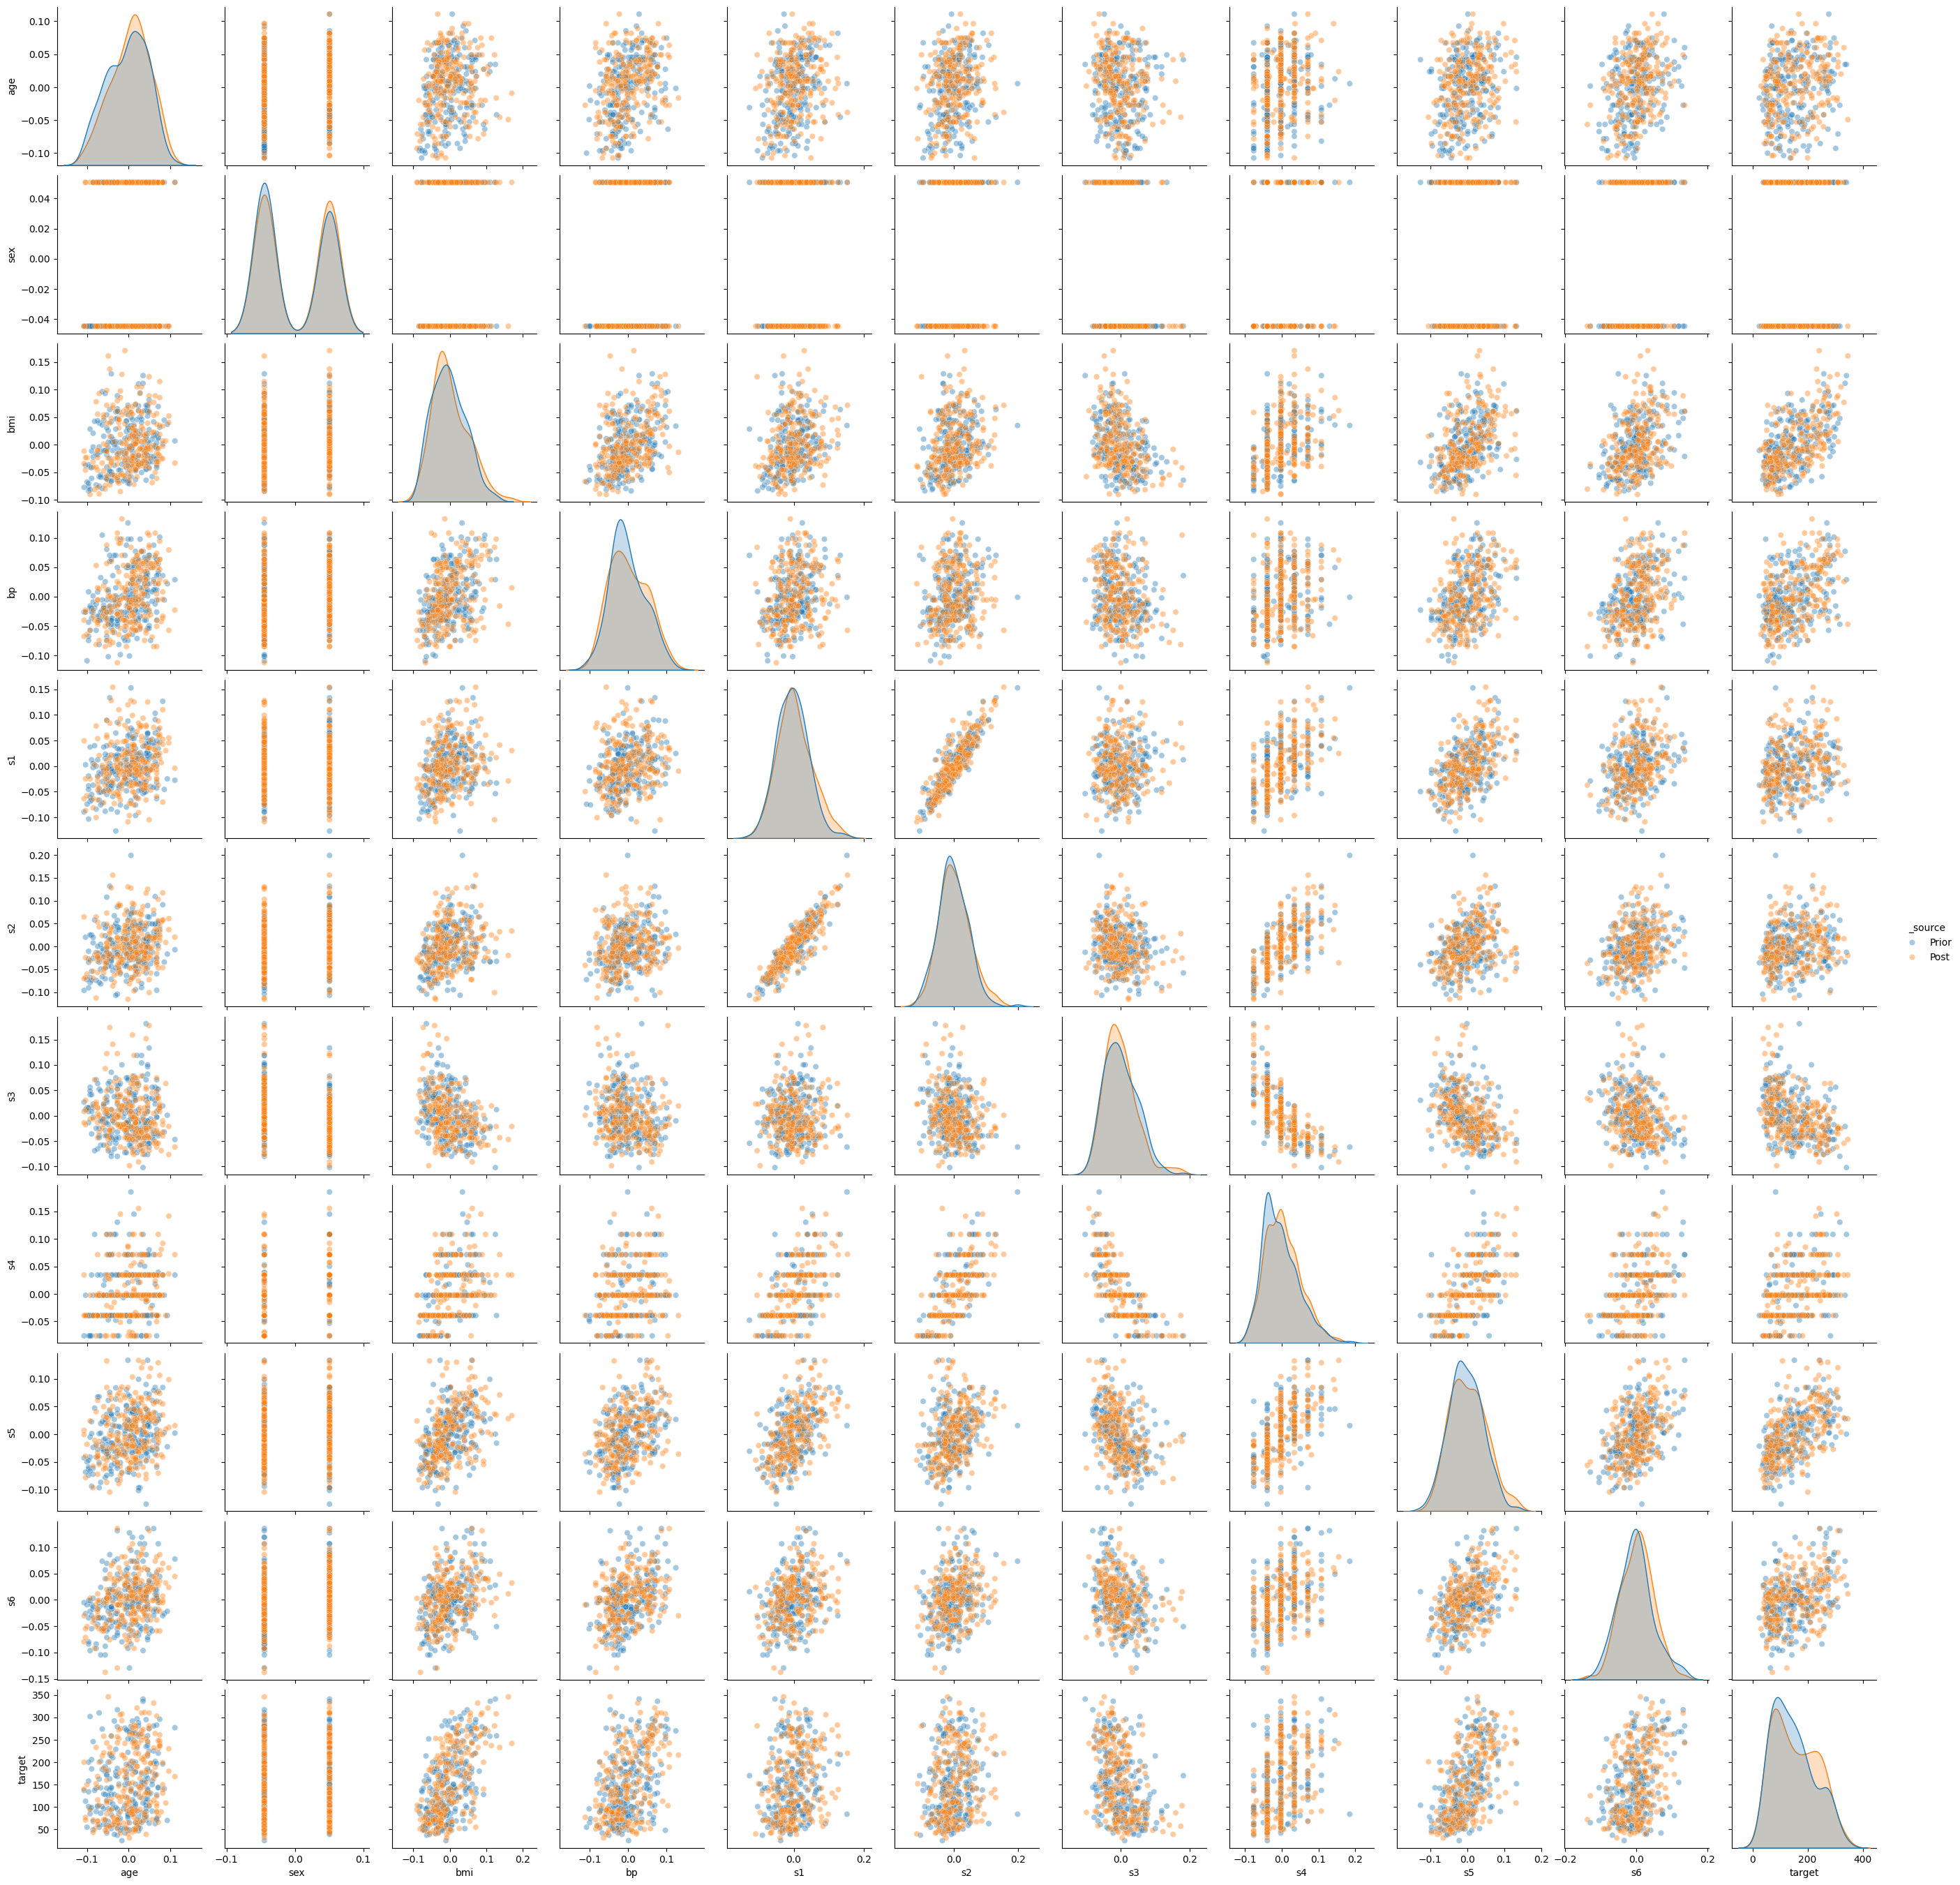

In [7]:
# plot numeric columns against each other in a pair grid
detector.plot_numeric_to_numeric(
    plot_kws={'alpha': 0.4},
    diag_kws={'common_norm': False}
)

Finally, you may compare the ML efficacy of the 2 datasets on a particular column

In [8]:
detector.compare_ml_efficacy(target_column='target')

No test data was provided. Test data will be created with a 70.0-30.0 shuffle split from the post data set.


,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,explained_variance_score,r2_score
Prior,56.137808,44.793249,0.375731,0.427789,0.427677
Post,55.274656,44.610709,0.424757,0.451622,0.445141


If the model trained with the prior dataset performed worse than that of the post data set, may suggest that an existing model (if any) built with the prior dataset is not performing well on the post data set, and that it may improve from some re-training.